# Task 1

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np 
from scipy.io import loadmat
import pandas as pd
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_auc_score, confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.image import ImageDataGenerator
import random
from sklearn.metrics import plot_confusion_matrix
import joblib 

In [7]:
np.random.seed(31415)

### Helper Functions

In [14]:
def scree_plot(title):
    n_comp = 20
    pca = PCA(n_components=n_comp)
    pc = pca.fit_transform(X_train)
    scree_df = pd.DataFrame({'exp_var':pca.explained_variance_ratio_,
                 'PC':[i for i in range(1,n_comp+1)]})
    colors = [n_comp * ['blue'] + (20-n_comp) * ['red'] ]
    scree_df['colors'] = colors[0]
    plt.figure(dpi=200)
    sns.barplot(x='PC',y="exp_var", 
               data=scree_df, color="c");
    
    plt.title(title)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Varaince')
    plt.tight_layout()
    
def pcplot2d(title):
    pca = PCA(n_components=2)
    pc = pca.fit_transform(X_train)
    pc_df = pd.DataFrame(data= pc, columns = ['PC1','PC2'])
    pc_df['class'] =y_train
    
    plt.figure(dpi=200)
#     ax = sns.lmplot( x="PC1", y="PC2",
#       data=pc_df, 
#       fit_reg=False, 
#         hue='class', 
#       legend=True,
#       scatter_kws={"s": 80})
    sns.scatterplot(data=pc_df, x="PC1", y="PC2", hue="class", size=80, palette='deep')
    plt.title(title)
    plt.tight_layout() 
    
def pcplot3d():
    pca = PCA(n_components=3)
    pc = pca.fit_transform(data)
    pc_df = pd.DataFrame(data= pc, columns = ['PC1','PC2','PC3'])

    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(pc_df['PC1'], pc_df['PC2'], pc_df['PC3'], c=labels,depthshade=False)
    
def training_plot(model):
    results = pd.DataFrame(model.cv_results_)
    x = results['param_pca__n_components']
    y = results['mean_test_score']

    best_x = results[results['rank_test_score']==1]['param_pca__n_components']
    best_y = results[results['rank_test_score']==1]['mean_test_score']

    plt.figure(figsize=(6,4))
    sns.lineplot(x,y)
    plt.scatter(best_x,best_y,c='red',label='Highest Accuracy')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Mean Accuracy Score')
    # plt.title('Bayes Models: Number of Principal Components')
    plt.legend(loc=(.6,0.08))

def training_time_plot(model):
    results = pd.DataFrame(model.cv_results_)
    x = results['param_pca__n_components']
    y = results['mean_fit_time']

    best_x = results[results['rank_test_score']==1]['param_pca__n_components']
    best_y = results[results['rank_test_score']==1]['mean_fit_time']

    plt.figure(figsize=(6,4))
    sns.lineplot(x,y)
    plt.scatter(best_x,best_y,c='red',label='Highest Accuracy')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Mean Training Time')
    plt.legend()

def model_eval(model, X_test, y_test):
    ypred = model.predict(X_test)
    results = {'Accuracy' : [accuracy_score(y_test, ypred)],
               'F1': [f1_score(y_test, ypred)], 
               'Precision': [precision_score(y_test, ypred)],
                'Recall': [recall_score(y_test, ypred)], 
           'AUC': [roc_auc_score(y_test, ypred)]}
    results_df = pd.DataFrame(results)
    
#     results_df = results_df.style.hide_index()
    return results_df

def confusion_matrix(model, X_test, y_test, labels_list):
    ypred = model.predict(X_test)
    mat = confusion_matrix(y_test, ypred) 
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                        xticklabels=labels_list,
                        yticklabels=labels_list)
    plt.xlabel('true label')
    plt.ylabel('predicted label');

In [9]:
#load data chunks and converts to numpy arrays
def load_data_chunks():
    raw_face = np.array(loadmat('./data/data.mat')['face'])
    raw_pose = np.array(loadmat('./data/pose.mat')['pose'])
    raw_illum = np.array(loadmat('./data/illumination.mat')['illum'])
    aug_neutral = np.load('data/aug_neutral.npy', allow_pickle=True)
    aug_smile = np.load('data/aug_smile.npy', allow_pickle=True)
    return raw_face, (raw_pose, raw_illum), (aug_neutral,aug_smile)

def make_dataset(raw_face, num_illum, split=.15):
    np.random.seed(31)
    neutral= list(raw_face[:,:,::3].reshape((24*21,200)).transpose())
    smile = list(raw_face[:,:,1::3].reshape((24*21,200)).transpose())
    illum = list(raw_face[:,:,2::3].reshape((24*21,200)).transpose())
    np.random.shuffle(neutral) 
    np.random.shuffle(smile)
    np.random.shuffle(illum)
    X_train, y_train, X_test, y_test = [],[],[],[]
    split_half = int((400*split)/2)
    
    for i in range(split_half):
        X_test.append(neutral.pop())
        y_test.append(0)
        X_test.append(smile.pop())
        y_test.append(1)
    for i in range(200-split_half):
        X_train.append(neutral.pop())
        y_train.append(0)
        X_train.append(smile.pop())
        y_train.append(1)
    for i in range(num_illum):
        X_train.append(illum.pop())
        y_train.append(0)
    
    train = list(zip(X_train, y_train))
    np.random.shuffle(train)
    train = np.array(train)
    X_train, y_train = train[:,0], train[:,1]
    X_train = np.array([X_train[i].reshape(504) for i in range(((200-split_half)*2) +num_illum)])
    
    test = list(zip(X_test, y_test))
    np.random.shuffle(test)
    test = np.array(test)
    X_test, y_test = test[:,0], test[:,1]
    X_test = np.array([X_test[i].reshape(504) for i in range(split_half*2)])
    
#     print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    return X_train, y_train.astype(int), X_test, y_test.astype(int)

## Data Exploration

In [19]:
raw_face, _, _ = load_data_chunks()
X_train, y_train, X_test, y_test = make_dataset(raw_face, num_illum=0)
# scree_plot(title='Face Data')
# plt.savefig('./graphics/face_scree.png')

In [20]:
# pcplot2d(title='Face Data')

In [23]:
def bayes():
    training_logs = {}
    testing_logs = {}
    augment, pca_param, acc, fone, prec, rec, au = [], [], [], [], [], [], []
    for aug in [0,100,200]:
        
        X_train, y_train, X_test, y_test = make_dataset(raw_face, num_illum=aug, split=.15)
        X_train = X_train/255
        X_test = X_test/255

        #pipeline components
        scaler = StandardScaler()
        pca = PCA()
        gnb = GaussianNB()

        param_grid = {
            'pca__n_components': [i for i in range(1,40)]
        }

        pipe = Pipeline(steps=[('pca', pca), ('bayes', gnb)])

        search = GridSearchCV(pipe, param_grid, scoring='accuracy', n_jobs=-1, cv=5)

        search.fit(X_train, y_train)

        training = pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score')[['rank_test_score',
                                                                'mean_test_score',
                                                                'std_test_score',
                                                                'param_pca__n_components']].head(5).set_index('rank_test_score')
        training_logs['training' + str(aug)] = training
        
        top_pca = list(training['param_pca__n_components'])
        accuracy, f1, precision, recall, auc = [], [], [], [], [] 
        for i in range(5):
            pca = PCA(n_components=top_pca[i])
            model = Pipeline(steps=[('pca', pca), ('bayes', gnb)])
            model.fit(X_train, y_train)
            results = model_eval(model, X_test, y_test)
            accuracy.append(results['Accuracy'][0])
            f1.append(results['F1'][0])
            precision.append(results['Precision'][0])
            recall.append(results['Recall'][0])
            auc.append(results['AUC'][0])

        testing = pd.DataFrame({'# of PC':top_pca, 'Accuracy':accuracy, 
                                        'F1':f1,'Precision':precision, 'Recall':recall, 'AUC':auc})
        testing = testing.sort_values(by="Accuracy", ascending =False)
        testing_logs['testing' + str(aug)] = testing
        
        log_entry = testing.head(1).values
        augment.append(aug)
        pca_param.append(log_entry[0][0])
        acc.append(log_entry[0][1])
        fone.append(log_entry[0][2])
        prec.append(log_entry[0][3])
        rec.append(log_entry[0][4])
        au.append(log_entry[0][5])
        

        best_n = int(testing.head(1).values[0][0])
        pca = PCA(n_components=best_n)
        best_model = Pipeline(steps=[('pca', pca), ('bayes', gnb)])
        best_model.fit(X_train, y_train)
        
        
    best_model_log = pd.DataFrame({'Augmented': augment,'PC':pca_param, 'Accuracy':acc, 'F1':fone, 'Precision':prec, 'Recall':rec, 'AUC':au}) 
    return best_model, best_model_log, training_logs, testing_logs
 
def knn():
    training_logs = {}
    testing_logs = {}
    augment, pca_param, knn_param, acc, fone, prec, rec, au = [], [], [], [], [], [], [], []
    # each aug value represents the amount of augmented samples included in the training data
    for aug in [0,100,200]:
        
        X_train, y_train, X_test, y_test = make_dataset(raw_face, num_illum=aug, split=.15)
        X_train = X_train/255
        X_test = X_test/255

        #pipeline components
        pca = PCA()
        knn = KNeighborsClassifier()
        pipe = Pipeline(steps=[('pca', pca), ('knn', knn)])
        param_grid = {
        'pca__n_components': [i for i in range(1,31)],
        'knn__n_neighbors' : [i for i in range(1,60)],     
        }

        pipe = Pipeline(steps=[('pca', pca), ('knn', knn)])

        search = GridSearchCV(pipe, param_grid, scoring='accuracy', n_jobs=-1, cv=5)

        search.fit(X_train, y_train)

        training = pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score')[['rank_test_score',
                                                      'mean_test_score',
                                                      'param_pca__n_components',
                                                      'param_knn__n_neighbors']].head(5).set_index('rank_test_score')
        training_logs['training' + str(aug)] = training
        
        top_pca = list(training['param_pca__n_components'])
        top_n_knn = list(training['param_knn__n_neighbors'])
        accuracy, f1, precision, recall, auc = [], [], [], [], [] 
        for i in range(5):
            pca = PCA(n_components=top_pca[i])
            knn = KNeighborsClassifier(n_neighbors=top_n_knn[i])
            model = Pipeline(steps=[('pca', pca), ('knn', knn)])
            model.fit(X_train, y_train)
            results = model_eval(model, X_test, y_test)
            accuracy.append(results['Accuracy'][0])
            f1.append(results['F1'][0])
            precision.append(results['Precision'][0])
            recall.append(results['Recall'][0])
            auc.append(results['AUC'][0])

        testing = pd.DataFrame({'# of PC':top_pca, '# of Neighbors': top_n_knn, 'Accuracy':accuracy, 
                                'F1':f1,'Precision':precision, 'Recall':recall, 'AUC':auc })
        testing = testing.sort_values(by="Accuracy", ascending =False)
        testing_logs['testing' + str(aug)] = testing
        
        log_entry = testing.head(1).values
        augment.append(aug)
        pca_param.append(log_entry[0][0])
        knn_param.append(log_entry[0][1])
        acc.append(log_entry[0][2])
        fone.append(log_entry[0][3])
        prec.append(log_entry[0][4])
        rec.append(log_entry[0][5])
        au.append(log_entry[0][6])
        

        best_pca_param = int(testing.head(1).values[0][0])
        best_knn_param = int(testing.head(1).values[0][1])
        pca = PCA(n_components=best_pca_param)
        knn = KNeighborsClassifier(n_neighbors=best_knn_param)
        best_model = Pipeline(steps=[('pca', pca), ('knn', knn)])
        best_model.fit(X_train, y_train)
        
        
    best_model_log = pd.DataFrame({'Augmented': augment,'PC':pca_param, '# of Neighbors': knn_param, 'Accuracy':acc, 
                                   'F1':fone, 'Precision':prec, 'Recall':rec, 'AUC':au}) 
    return best_model, best_model_log, training_logs, testing_logs
    

In [24]:
X_train, y_train, X_test, y_test = make_dataset(raw_face, num_illum=200, split=.15)
X_train = X_train/255
X_test = X_test/255

In [25]:
best_bayes_model, bayes_model_log, bayes_training_logs, bayes_testing_logs = bayes()
bayes_model_log

,Augmented,PC,Accuracy,F1,Precision,Recall,AUC
0,0,24.0,0.883333,0.872727,0.960000,0.800000,0.883333
1,100,17.0,0.883333,0.877193,0.925926,0.833333,0.883333
2,200,15.0,0.850000,0.836364,0.920000,0.766667,0.850000


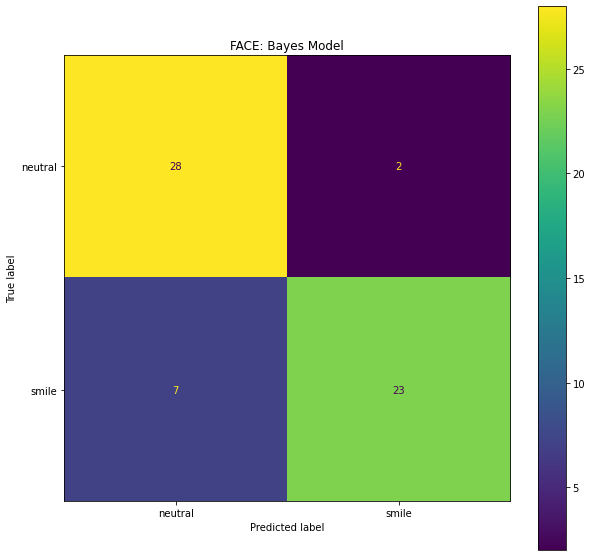

In [42]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(best_bayes_model, X_test, y_test, display_labels=['neutral','smile'], ax=ax)
plt.title('FACE: Bayes Model')
plt.savefig('./graphics/face_bayes_cm.png')

In [27]:
#save best knn model
joblib.dump(best_bayes_model, './models/face_bayes.pkl')

['./models/face_bayes.pkl']

In [28]:
best_knn_model, knn_model_log, training_logs, testing_logs = knn()
knn_model_log

,Augmented,PC,# of Neighbors,Accuracy,F1,Precision,Recall,AUC
0,0,19.0,43.0,0.883333,0.872727,0.960000,0.8,0.883333
1,100,24.0,45.0,0.900000,0.888889,1.000000,0.8,0.900000
2,200,29.0,39.0,0.866667,0.857143,0.923077,0.8,0.866667


In [29]:
testing_logs['testing200'

,# of PC,# of Neighbors,Accuracy,F1,Precision,Recall,AUC
0,29,39,0.866667,0.857143,0.923077,0.800000,0.866667
2,30,39,0.866667,0.857143,0.923077,0.800000,0.866667
4,27,35,0.850000,0.842105,0.888889,0.800000,0.850000
1,27,33,0.816667,0.807018,0.851852,0.766667,0.816667
3,23,25,0.816667,0.800000,0.880000,0.733333,0.816667


In [30]:
testing_logs['testing100']

,# of PC,# of Neighbors,Accuracy,F1,Precision,Recall,AUC
0,24,45,0.900000,0.888889,1.000000,0.800000,0.900000
2,30,43,0.900000,0.888889,1.000000,0.800000,0.900000
3,30,45,0.900000,0.888889,1.000000,0.800000,0.900000
1,23,45,0.883333,0.877193,0.925926,0.833333,0.883333
4,21,46,0.866667,0.857143,0.923077,0.800000,0.866667


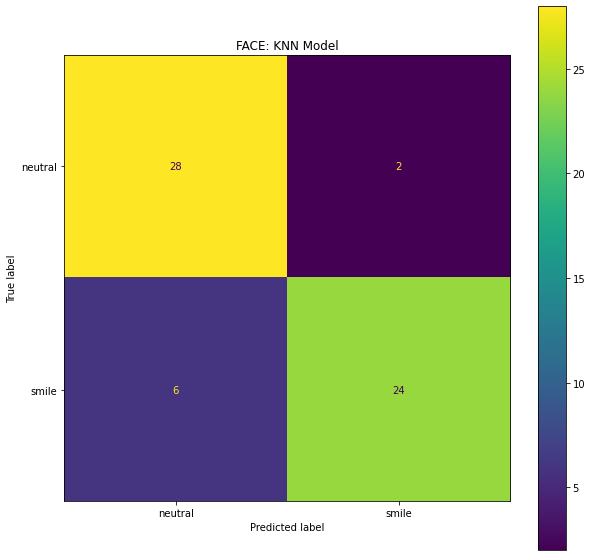

In [43]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(best_knn_model, X_test, y_test, display_labels=['neutral','smile'], ax=ax)
plt.title('FACE: KNN Model')
plt.savefig('./graphics/face_knn_cm.png')

In [70]:
#save best knn model
joblib.dump(best_knn_model,'./models/face_knn.pkl')

['./models/face_knn.pkl']